# RL Project - Actor Critic Network 

In [8]:
import numpy as np 
import gym
import minihack 
from nle import nethack 

import numpy as np 
import random
import matplotlib.pyplot as plt 
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import flatten

from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Helper Functions

In [10]:
def moving_average(a, n):
    """Calculates the moving average of an array a with a window size n"""
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

In [11]:
def display_screen(state):
    """Displays the state as the screen in image form using the 'pixel' observation key"""
    screen = Image.fromarray(np.uint8(state['pixel']))
    display(screen)

In [12]:
def format_state(state):
    """Formats the state according to the input requirements of the Actor Critic Neural Network"""
    
    # Normalize and reshape for convolutional layer input
    glyphs = state["glyphs"]
    glyphs = glyphs/glyphs.max()
    glyphs = glyphs.reshape((1,1,21,79))
    
    # Normalize the message and reshape for the fully connected layer input 
    message = state["message"]
    if state["message"].max()>0: 
        # Occassionally the message is empty which will cause a Zero Division error 
        message = message/message.max()
    message = message.reshape((1,len(message)))
    
    state = {"glyphs":glyphs,"message":message}
    return state

In [13]:
def compute_returns(rewards, gamma):
    """Computes the discounted returns of a sequence of rewards achieved in a trajectory"""
    returns = []
    r= 0
    for reward in rewards[::-1]:
        r = reward + gamma*r
        returns.append(r)
    returns.reverse()
    returns = np.array(returns)
    
    # Standardize Returns 
    if np.mean(returns)!= 0:
         returns = returns - np.mean(returns)
    if np.std(returns) != 0:
        returns = returns/ np.std(returns)

    return returns

In [14]:
def plot_results(env_name,scores, color='blue'):
    """Plots the reward attained by an Agent at each step of training in 
        an environment for each iteration and average over all iterations"""
    
    plt.figure(figsize=(8,6))
    
    # Plot individual iterations 
    for score in scores:
        plt.plot(score, alpha =0.1, color=color)
    
    # Plot mean over all iterations
    mean = np.mean(scores,axis=0)
    plt.plot(mean, color=color,label="Mean Reward")
    
    plt.title(f"Actor Critic - {env_name}")
    plt.xlabel("Episode Number")
    plt.ylabel("Reward")
    
    plt.yticks(np.arange(-11, 2, 1.00))
    #splt.ylim(-12,2)
    plt.legend(loc=4)
    plt.savefig(f"Actor-Critic-{env_name}.pdf")
    plt.show()

## Model 

In [15]:
class ActorCritic(nn.Module):
    """The Actor Critic Neural Network used to estimate the state value function and action probabilities"""
    def __init__(self,s_size=8,h_size=128, a_size=4):
        
        # The network architecture follows the popular lenet-5 CNN architeture 
        super(ActorCritic, self).__init__()
        
        # Initialize first set of convolutional and pooling layers with a ReLU activation function 
        self.conv1 = Conv2d(in_channels=1, out_channels=20,
                            kernel_size=(5, 5))
        self.relu1 = ReLU()
        self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        # Initialize second set of of convolutional and pooling layers with a ReLU activation function 
        self.conv2 = Conv2d(in_channels=20, out_channels=50,
                            kernel_size=(5, 5))
        self.relu2 = ReLU()
        self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        # Initialize fully connected layers for glyph output after convolutional and pooling layers
        self.fc1 = Linear(in_features=1600, out_features=500)
        self.relu3 = ReLU()
        self.fc2 = Linear(in_features=500, out_features=128)
        self.relu4 = ReLU()
        
        # Initialize fully connected for message input 
        self.fc3 = Linear(in_features=256, out_features=128)
        self.relu5 = ReLU()
        
        # Initialize fully connected for combination of glyphs and message 
        self.fc4 = Linear(in_features=256, out_features=128)
        self.relu6 = ReLU()

        # To estimate the value function of the state 
        self.value_layer = nn.Linear(128, 1)

        # To calculate the probability of taking each action in the given state
        self.action_layer = nn.Linear(128, a_size)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, state):
        
        # Transform the glyph and state arrays into tensors 
        glyphs_t  = torch.from_numpy(state["glyphs"]).float().to(device)
        message_t  = torch.from_numpy(state["message"]).float().to(device)

        # Pass the 2D glyphs input through our convolutional and pooling layers 
        glyphs_t = self.conv1(glyphs_t)
        glyphs_t = self.relu1(glyphs_t)
        glyphs_t = self.maxpool1(glyphs_t)
        glyphs_t = self.conv2(glyphs_t)
        glyphs_t = self.relu2(glyphs_t)
        glyphs_t = self.maxpool2(glyphs_t)
        
        # Platten the output from the final pooling layer and pass it through the fully connected layers 
        glyphs_t = glyphs_t.reshape(glyphs_t.shape[0], -1)
        glyphs_t = self.fc1(glyphs_t)
        glyphs_t = self.relu3(glyphs_t)
        glyphs_t = self.fc2(glyphs_t)
        glyphs_t = self.relu4(glyphs_t)
        
        # Pass the message input through a fully connected layer
        message_t = self.fc3(message_t)
        message_t = self.relu5(message_t)
        
        # Combine glyphs output from convolution and fully connected layers 
        # with message output from fully connected layer 
        try:
            combined = torch.cat((glyphs_t,message_t),1)
        except:
            combined = torch.concat([glyphs_t,message_t],1)

        # Pass glyphs and messaged combination through a fully connected layer
        combined = self.fc4(combined)
        combined = self.relu6(combined)
        
        # Pass the output from the previous fully connected layer through two seperate 
        # fully connected layers, one with a single output neuron (to estimate the state value function)
        # and the other with the number of output neurons equal to the number of actions 
        # (to estimate the action probabilities)
        state_value = self.value_layer(combined)
        
        action_probs = self.action_layer(combined)
        action_probs = self.softmax(action_probs)
        
        return action_probs,state_value

## Actor Critic Method

In [16]:
def actor_critic(env, model, seed, learning_rate, number_episodes, max_episode_length, gamma, verbose=True):
    """
    Method to train Actor Critic model.
    
    Input:
    env: The environment to be used during training
    seed: The random seed for any random operations performed 
    learning_rate: The learning rate uesd for the Adam optimizer when training the model 
    number_episodes: Number of episodes to train for 
    max_episode_length: The maximum number of steps to take in an episode before terminating
    gamma: The discount factor used when calculating the discounted rewards of an episode
    verbose: Print episode reward after each episode
    
    Returns:
    policy: The neural network model after training that approximates the state value functions and action probabilities
    scores: The cumulative reward achieved by the agent for each episode during traiing
    """
    # Setting random seeds (for reproducibility)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    env.seed(seed)
    
    # Initialize optimizer for Actor Critic Network
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # List to store the rewards attained in each episode 
    scores =[]
    
    for i in range(number_episodes):
        # Reset environment
        state = format_state(env.reset())
        # Flag to see if episode has terminated
        done = False
        
        # Lists to store the rewards acquired, the log_probability of the actions and
        # the value function of the states visited in this episode 
        rewards = []
        log_probs = []
        state_values = []
        
        for t in range(1, max_episode_length):
            
            # Get the probability distribution over actions and 
            # estimated state value function from Actor Critic network 
            action_probs,state_value = model.forward(state)
            distribution = torch.distributions.Categorical(action_probs)
            # Sample from the probability distribution to determine which action to take 
            action = distribution.sample()
            
            # Take selected action, observe the reward received, the next state 
            # and whether or not the episode terminated 
            next_state, reward, done, _ = env.step(action.item())
            next_state = format_state(next_state)
    
            # Store the reward, log of the probability of the action selected 
            # And
            rewards.append(reward)
            log_probs.append(distribution.log_prob(action))
            state_values.append(state_value)
            
            state = next_state
            
            if done:
                break
        
        # Store the reward acquired in the episode and calculate the discounted return of the episode
        scores.append(np.sum(rewards))
        returns = compute_returns(rewards, gamma)
        returns = torch.from_numpy(returns).float().to(device)
        
        # Print the episode, the reward acquired in the episode and the mean reward over the last 50 episodes 
        if verbose:
            print("Episode:",i,"Reward:",np.sum(rewards),"Average Reward:",np.mean(scores[-50:]),"Steps",t)
        
        # Calculate the loss for the episode and use it to update the network parameters 
        loss = 0
        for logprob, value, reward in zip(log_probs, state_values, returns):
            advantage = reward  - value.item()
            action_loss = -logprob * advantage
            try:
                reward = reward.resize(1,1)
            except:pass
            value_loss = F.smooth_l1_loss(value, reward)
            loss += (action_loss + value_loss)   
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 
        
    # Store the policy as the neural network model at the final iteration 
    policy = model

    return policy, scores

In [17]:
def run_actor_critic(env,number_episodes,max_episode_length,iterations):
    """Trains Actor Critic model for a number of episodes on a given environment"""
    seeds = np.random.randint(1000, size=iterations)
    scores_arr = [] 
    
    for seed in seeds:
        # Initialize the Actor Critic Model 
        ac_model = ActorCritic(h_size=512, a_size=env.action_space.n).to(device)

        # Train the Actor Critic Model 
        policy, scores = actor_critic(env=env,
                                    model= ac_model, 
                                    seed=seed, 
                                    learning_rate=0.02,
                                    number_episodes=number_episodes, 
                                    max_episode_length=max_episode_length, 
                                    gamma=0.99 ,
                                    verbose=True)
        
        # Store rewards for this iteration 
        scores_arr.append(scores)
        
    return scores_arr

## Testing

## 1.1 Navigation - Room 5x5 

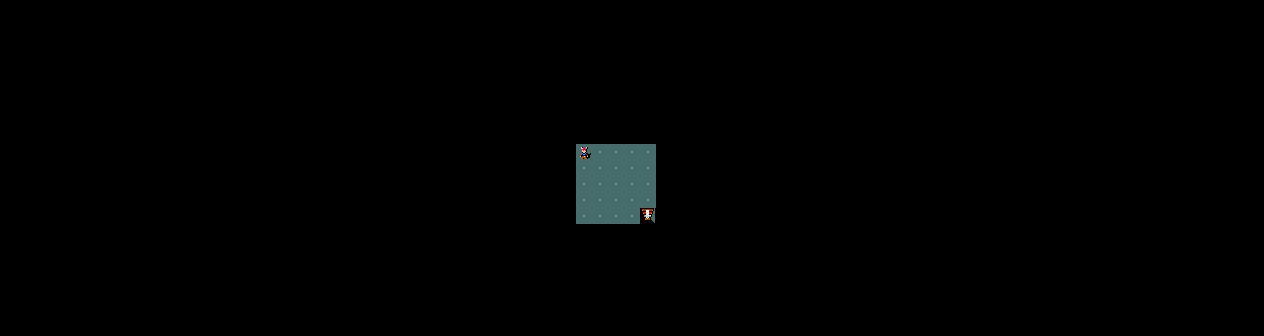

In [13]:
# Create the environment with the observations keys required as input to the Actor Critic Neural Network 
# The max number of epsidoe steps for the environment needs to be increased as it defaults to 250 for Navigation tasks
env = gym.make("MiniHack-Room-5x5-v0", observation_keys=["glyphs","pixel","message"],max_episode_steps=1000)

# Reset the environment and display the screen of the starting state 
display_screen(env.reset())

In [64]:
room_5x5_scores = run_actor_critic(env,number_episodes=100,max_episode_length=1000,iterations=5)

Episode: 0 Reward: 0.69 Average Reward: 0.69 Steps 140


/opt/homebrew/Caskroom/miniforge/base/envs/minihack/lib/python3.9/site-packages/torch/_tensor.py:493: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


KeyboardInterrupt: 

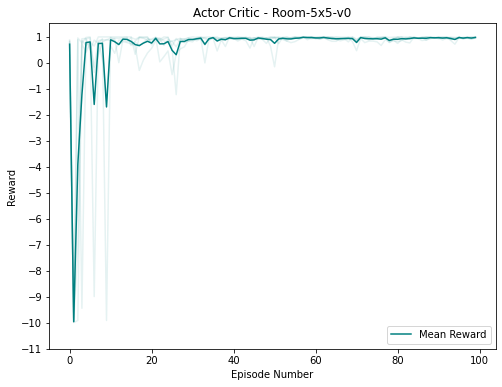

In [80]:
plot_results(env_name="Room-5x5-v0",scores=room_5x5_scores, color = "teal" )

## 1.2 Navigation - Room 15x15  

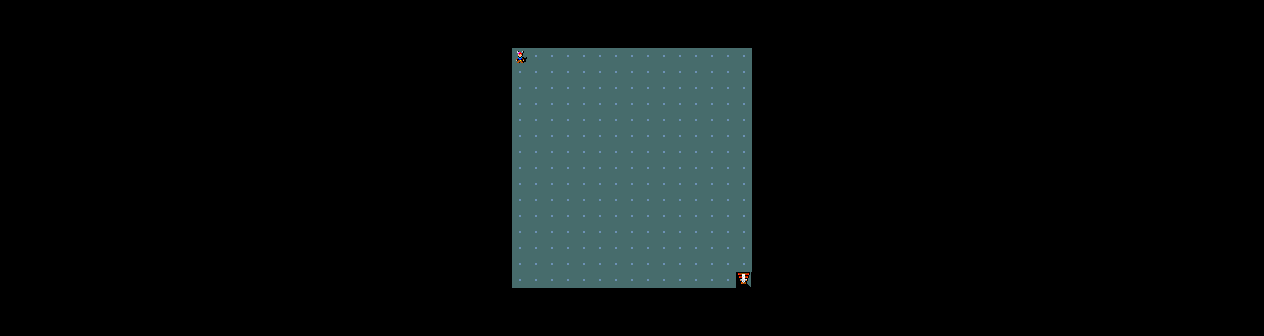

In [118]:
# Create the environment with the observations keys required as input to the Actor Critic Neural Network 
env = gym.make("MiniHack-Room-15x15-v0", observation_keys=["glyphs","pixel","message"],max_episode_steps=1000)

# Reset the environment and display the screen of the starting state 
display_screen(env.reset())

In [119]:
room_15x15_scores = run_actor_critic(env,number_episodes=100, max_episode_length=1000,iterations=5)

Episode: 0 Reward: 0.7599999999999999 Average Reward: 0.7599999999999999 Steps 179
Episode: 1 Reward: -9.85 Average Reward: -4.545 Steps 999
Episode: 2 Reward: 0.6199999999999999 Average Reward: -2.8233333333333337 Steps 137
Episode: 3 Reward: 0.82 Average Reward: -1.9125 Steps 78
Episode: 4 Reward: 0.75 Average Reward: -1.3800000000000001 Steps 140
Episode: 5 Reward: 0.8799999999999999 Average Reward: -1.0033333333333334 Steps 120
Episode: 6 Reward: 0.69 Average Reward: -0.7614285714285715 Steps 250
Episode: 7 Reward: 0.8 Average Reward: -0.56625 Steps 140
Episode: 8 Reward: 0.72 Average Reward: -0.4233333333333334 Steps 156
Episode: 9 Reward: 0.82 Average Reward: -0.29900000000000004 Steps 235
Episode: 10 Reward: 0.86 Average Reward: -0.19363636363636372 Steps 88
Episode: 11 Reward: 0.85 Average Reward: -0.10666666666666673 Steps 91
Episode: 12 Reward: 0.91 Average Reward: -0.028461538461538514 Steps 51
Episode: 13 Reward: -0.5199999999999998 Average Reward: -0.0635714285714286 Steps

Episode: 17 Reward: -0.5099999999999998 Average Reward: -0.495 Steps 241
Episode: 18 Reward: 0.08999999999999986 Average Reward: -0.46421052631578946 Steps 262
Episode: 19 Reward: -0.47999999999999987 Average Reward: -0.465 Steps 212
Episode: 20 Reward: -0.6000000000000002 Average Reward: -0.4714285714285714 Steps 264
Episode: 21 Reward: 0.21999999999999986 Average Reward: -0.44 Steps 144
Episode: 22 Reward: 0.53 Average Reward: -0.3978260869565218 Steps 161
Episode: 23 Reward: 0.85 Average Reward: -0.3458333333333334 Steps 88
Episode: 24 Reward: 0.6699999999999999 Average Reward: -0.3052 Steps 101
Episode: 25 Reward: -0.33999999999999986 Average Reward: -0.30653846153846154 Steps 196
Episode: 26 Reward: 0.78 Average Reward: -0.2662962962962963 Steps 94
Episode: 27 Reward: 0.93 Average Reward: -0.2235714285714286 Steps 85
Episode: 28 Reward: 0.75 Average Reward: -0.19000000000000003 Steps 113
Episode: 29 Reward: 0.6499999999999999 Average Reward: -0.16200000000000003 Steps 169
Episode:

Episode: 30 Reward: 0.96 Average Reward: -0.587741935483871 Steps 68
Episode: 31 Reward: 0.76 Average Reward: -0.5456249999999999 Steps 133
Episode: 32 Reward: 0.95 Average Reward: -0.5003030303030302 Steps 82
Episode: 33 Reward: 0.73 Average Reward: -0.46411764705882347 Steps 72
Episode: 34 Reward: 0.97 Average Reward: -0.42314285714285704 Steps 67
Episode: 35 Reward: 0.52 Average Reward: -0.3969444444444444 Steps 167
Episode: 36 Reward: 0.5599999999999999 Average Reward: -0.371081081081081 Steps 108
Episode: 37 Reward: 0.71 Average Reward: -0.34263157894736834 Steps 67
Episode: 38 Reward: 0.85 Average Reward: -0.31205128205128196 Steps 64
Episode: 39 Reward: 1.0 Average Reward: -0.27925 Steps 35
Episode: 40 Reward: 0.94 Average Reward: -0.24951219512195122 Steps 81
Episode: 41 Reward: 0.87 Average Reward: -0.2228571428571429 Steps 65
Episode: 42 Reward: 0.89 Average Reward: -0.19697674418604652 Steps 65
Episode: 43 Reward: 0.6 Average Reward: -0.1788636363636364 Steps 78
Episode: 44 

Episode: 52 Reward: 1.0 Average Reward: 0.8154 Steps 14
Episode: 53 Reward: 1.0 Average Reward: 0.9468000000000001 Steps 14
Episode: 54 Reward: 1.0 Average Reward: 0.96 Steps 14
Episode: 55 Reward: 1.0 Average Reward: 0.9626 Steps 14
Episode: 56 Reward: 1.0 Average Reward: 0.9690000000000001 Steps 14
Episode: 57 Reward: 1.0 Average Reward: 0.972 Steps 14
Episode: 58 Reward: 1.0 Average Reward: 0.9741999999999998 Steps 14
Episode: 59 Reward: 1.0 Average Reward: 0.9772 Steps 14
Episode: 60 Reward: 1.0 Average Reward: 0.9790000000000001 Steps 14
Episode: 61 Reward: 1.0 Average Reward: 0.9802000000000001 Steps 14
Episode: 62 Reward: 1.0 Average Reward: 0.9808 Steps 14
Episode: 63 Reward: 1.0 Average Reward: 0.9845999999999999 Steps 14
Episode: 64 Reward: 1.0 Average Reward: 0.9853999999999999 Steps 14
Episode: 65 Reward: 0.5299999999999999 Average Reward: 0.9786000000000001 Steps 63
Episode: 66 Reward: 1.0 Average Reward: 0.9798 Steps 14
Episode: 67 Reward: 1.0 Average Reward: 0.9892 Steps

Episode: 72 Reward: 0.7999999999999999 Average Reward: 0.8344 Steps 56
Episode: 73 Reward: 0.88 Average Reward: 0.8338 Steps 46
Episode: 74 Reward: 0.8 Average Reward: 0.8336 Steps 58
Episode: 75 Reward: 0.98 Average Reward: 0.8369999999999999 Steps 32
Episode: 76 Reward: 0.99 Average Reward: 0.8416 Steps 29
Episode: 77 Reward: 0.91 Average Reward: 0.8404 Steps 41
Episode: 78 Reward: 0.87 Average Reward: 0.8407999999999999 Steps 41
Episode: 79 Reward: 0.95 Average Reward: 0.84 Steps 35
Episode: 80 Reward: 0.89 Average Reward: 0.8384 Steps 46
Episode: 81 Reward: 0.98 Average Reward: 0.8382 Steps 33
Episode: 82 Reward: 0.9 Average Reward: 0.8375999999999999 Steps 43
Episode: 83 Reward: 1.0 Average Reward: 0.841 Steps 30
Episode: 84 Reward: 0.93 Average Reward: 0.8467999999999999 Steps 35
Episode: 85 Reward: 0.92 Average Reward: 0.8472 Steps 39
Episode: 86 Reward: 1.0 Average Reward: 0.8482 Steps 30
Episode: 87 Reward: 0.96 Average Reward: 0.8533999999999999 Steps 32
Episode: 88 Reward: 0

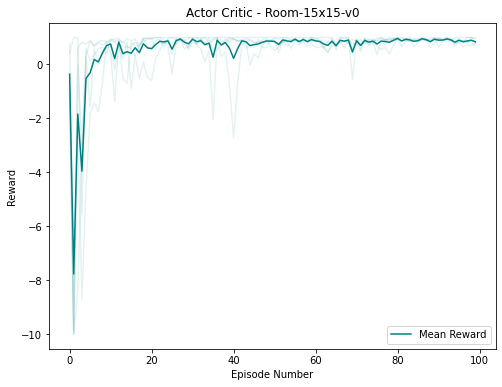

In [120]:
plot_results(env_name="Room-15x15-v0",scores=room_15x15_scores, color = "teal" )

## 1.3 Navigation - MazeWalk 9x9 

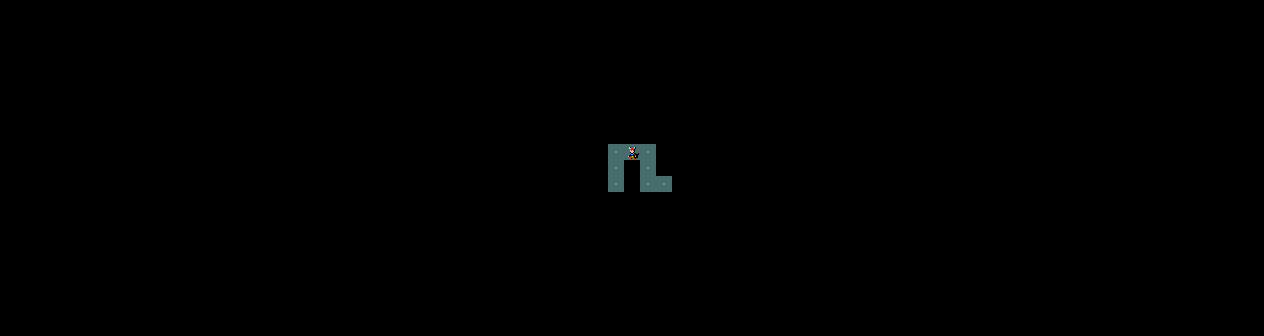

In [121]:
# Create the environment with the observations keys required as input to the Actor Critic Neural Network 
# Once again we need to set the max_episode_steps to larger than the default 250 for the more compicated environment
env = gym.make("MiniHack-MazeWalk-9x9-v0", observation_keys=["glyphs","pixel","message"],max_episode_steps=10000)

# Reset the environment and display the screen of the starting state 
display_screen(env.reset())

In [122]:
maze_9x9_scores = run_actor_critic(env,number_episodes=100,max_episode_length=10000,iterations=2)

Episode: 0 Reward: 0.78 Average Reward: 0.78 Steps 36


/opt/homebrew/Caskroom/miniforge/base/envs/minihack/lib/python3.9/site-packages/torch/_tensor.py:493: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


KeyboardInterrupt: 

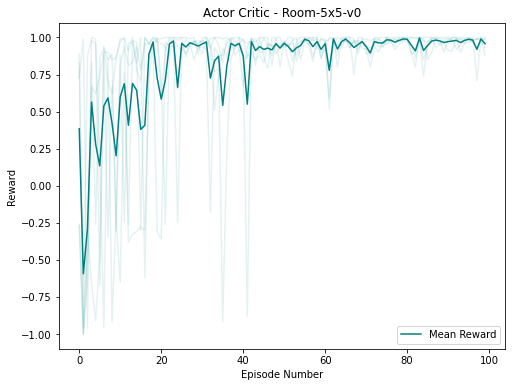

In [93]:
plot_results(env_name="MazeWalk-9x9-v0",scores=room_15x15_scores, color = "teal" )

## 2.1 Skill Acquisition - Eat 

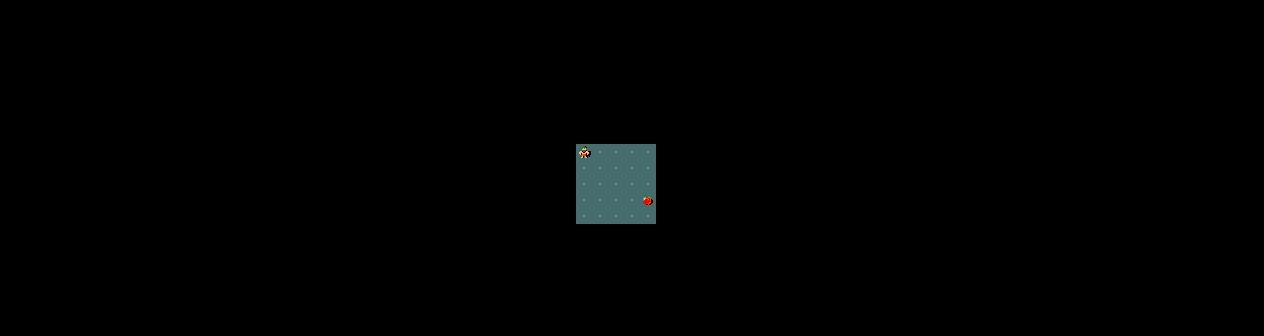

In [127]:
# By default Skill Acquisition tasks have an action space consisting of the full 78 actions available 
# Because most of these actions are unnecessary for smaller tasks we restrict the action space to the necessary 
# actions necesssary to complete the task in each environment only 
MOVE_ACTIONS = tuple(nethack.CompassDirection) # These are the cardinal directions
EAT_ACTIONS = MOVE_ACTIONS + (nethack.Command.EAT,) # Eat is to complete an episode by confirmation 


# Create the environment with the restricted action space as well as
# the observations keys required as input to the Actor Critic Neural Network 
env = gym.make("MiniHack-Eat-v0", observation_keys=["glyphs","pixel","message"],
               actions = EAT_ACTIONS, max_episode_steps=1000)
 
# Reset the environment and display the screen of the starting state 
display_screen(env.reset())

In [ ]:
# For skills acquisition tasks more training is required so not only are the episodes longer 
# but the number of episodes is also increased from 100 to 1000 
eat_scores = run_actor_critic(env,number_episodes=250,max_episode_length=1000,iterations=5)

Episode: 0 Reward: 0.9 Average Reward: 0.9 Steps 60


/opt/homebrew/Caskroom/miniforge/base/envs/minihack/lib/python3.9/site-packages/torch/_tensor.py:493: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Episode: 1 Reward: -9.95 Average Reward: -4.5249999999999995 Steps 999
Episode: 2 Reward: 0.95 Average Reward: -2.6999999999999997 Steps 20
Episode: 3 Reward: 0.5999999999999999 Average Reward: -1.875 Steps 87
Episode: 4 Reward: 0.94 Average Reward: -1.312 Steps 17
Episode: 5 Reward: 0.16000000000000014 Average Reward: -1.0666666666666667 Steps 108
Episode: 6 Reward: 0.25 Average Reward: -0.8785714285714287 Steps 103
Episode: 7 Reward: -4.64 Average Reward: -1.34875 Steps 587
Episode: 8 Reward: 0.73 Average Reward: -1.1177777777777775 Steps 55
Episode: 9 Reward: 0.84 Average Reward: -0.9219999999999999 Steps 44
Episode: 10 Reward: 0.87 Average Reward: -0.759090909090909 Steps 45
Episode: 11 Reward: 0.9299999999999999 Average Reward: -0.6183333333333333 Steps 15
Episode: 12 Reward: 0.94 Average Reward: -0.4984615384615385 Steps 20
Episode: 13 Reward: 0.8999999999999999 Average Reward: -0.3985714285714286 Steps 32
Episode: 14 Reward: 0.86 Average Reward: -0.31466666666666665 Steps 52
Epi

Episode: 125 Reward: 0.98 Average Reward: 0.9713999999999998 Steps 12
Episode: 126 Reward: 1.0 Average Reward: 0.9745999999999999 Steps 6
Episode: 127 Reward: 0.97 Average Reward: 0.9748 Steps 12
Episode: 128 Reward: 0.99 Average Reward: 0.9758000000000001 Steps 7
Episode: 129 Reward: 0.99 Average Reward: 0.9766000000000001 Steps 8
Episode: 130 Reward: 0.96 Average Reward: 0.9774 Steps 10
Episode: 131 Reward: 1.0 Average Reward: 0.9782000000000001 Steps 5
Episode: 132 Reward: 1.0 Average Reward: 0.9786000000000001 Steps 6
Episode: 133 Reward: 1.0 Average Reward: 0.98 Steps 6
Episode: 134 Reward: 0.99 Average Reward: 0.98 Steps 10
Episode: 135 Reward: 0.94 Average Reward: 0.9788000000000001 Steps 12
Episode: 136 Reward: 0.99 Average Reward: 0.9788000000000001 Steps 6
Episode: 137 Reward: 0.98 Average Reward: 0.9790000000000001 Steps 8
Episode: 138 Reward: 0.98 Average Reward: 0.9793999999999998 Steps 7
Episode: 139 Reward: 0.99 Average Reward: 0.9796 Steps 6
Episode: 140 Reward: 0.99 Av

Episode: 13 Reward: 0.81 Average Reward: -0.737142857142857 Steps 89
Episode: 14 Reward: 0.91 Average Reward: -0.6273333333333332 Steps 46
Episode: 15 Reward: 1.0 Average Reward: -0.5256249999999998 Steps 4
Episode: 16 Reward: 0.99 Average Reward: -0.4364705882352939 Steps 11
Episode: 17 Reward: 0.92 Average Reward: -0.36111111111111094 Steps 18
Episode: 18 Reward: 0.97 Average Reward: -0.2910526315789472 Steps 9
Episode: 19 Reward: 0.96 Average Reward: -0.22849999999999984 Steps 21
Episode: 20 Reward: 0.96 Average Reward: -0.17190476190476175 Steps 25
Episode: 21 Reward: 0.99 Average Reward: -0.11909090909090893 Steps 7
Episode: 22 Reward: 0.95 Average Reward: -0.07260869565217376 Steps 14
Episode: 23 Reward: 1.0 Average Reward: -0.02791666666666659 Steps 9
Episode: 24 Reward: 0.98 Average Reward: 0.012400000000000072 Steps 12
Episode: 25 Reward: 1.0 Average Reward: 0.05038461538461546 Steps 6
Episode: 26 Reward: 1.0 Average Reward: 0.08555555555555562 Steps 10
Episode: 27 Reward: 0.7

Episode: 139 Reward: 0.85 Average Reward: 0.9481999999999999 Steps 23
Episode: 140 Reward: 0.97 Average Reward: 0.9486 Steps 11
Episode: 141 Reward: 0.94 Average Reward: 0.9495999999999999 Steps 14
Episode: 142 Reward: 0.9299999999999999 Average Reward: 0.9486 Steps 15
Episode: 143 Reward: 0.89 Average Reward: 0.9472 Steps 22
Episode: 144 Reward: 0.95 Average Reward: 0.9466 Steps 13
Episode: 145 Reward: 0.97 Average Reward: 0.9468000000000001 Steps 11
Episode: 146 Reward: 0.8499999999999999 Average Reward: 0.9445999999999999 Steps 24
Episode: 147 Reward: 0.96 Average Reward: 0.9446000000000001 Steps 14
Episode: 148 Reward: 0.92 Average Reward: 0.9438000000000001 Steps 22
Episode: 149 Reward: 0.98 Average Reward: 0.944 Steps 11
Episode: 150 Reward: 0.99 Average Reward: 0.9444 Steps 9
Episode: 151 Reward: 0.98 Average Reward: 0.9448000000000001 Steps 11
Episode: 152 Reward: 0.98 Average Reward: 0.9447999999999999 Steps 10
Episode: 153 Reward: 0.97 Average Reward: 0.945 Steps 11
Episode: 

Episode: 14 Reward: 0.97 Average Reward: 0.13266666666666682 Steps 26
Episode: 15 Reward: 0.9 Average Reward: 0.1806250000000001 Steps 17
Episode: 16 Reward: 0.76 Average Reward: 0.21470588235294125 Steps 70
Episode: 17 Reward: 0.91 Average Reward: 0.2533333333333334 Steps 43
Episode: 18 Reward: 0.9 Average Reward: 0.28736842105263166 Steps 33
Episode: 19 Reward: 0.94 Average Reward: 0.3200000000000001 Steps 26
Episode: 20 Reward: 0.97 Average Reward: 0.350952380952381 Steps 17
Episode: 21 Reward: 0.95 Average Reward: 0.3781818181818183 Steps 15
Episode: 22 Reward: 0.98 Average Reward: 0.40434782608695663 Steps 15
Episode: 23 Reward: 0.8200000000000001 Average Reward: 0.4216666666666667 Steps 27
Episode: 24 Reward: 0.7399999999999999 Average Reward: 0.43440000000000006 Steps 32
Episode: 25 Reward: 0.99 Average Reward: 0.4557692307692308 Steps 12
Episode: 26 Reward: 0.99 Average Reward: 0.4755555555555556 Steps 9
Episode: 27 Reward: 0.9 Average Reward: 0.49071428571428577 Steps 23
Episo

Episode: 139 Reward: 1.0 Average Reward: 0.9632 Steps 5
Episode: 140 Reward: 0.97 Average Reward: 0.9643999999999999 Steps 11
Episode: 141 Reward: 1.0 Average Reward: 0.965 Steps 6
Episode: 142 Reward: 0.97 Average Reward: 0.9653999999999999 Steps 10
Episode: 143 Reward: 0.98 Average Reward: 0.9653999999999998 Steps 7
Episode: 144 Reward: 0.99 Average Reward: 0.966 Steps 7
Episode: 145 Reward: 0.94 Average Reward: 0.9673999999999999 Steps 15
Episode: 146 Reward: 0.99 Average Reward: 0.9682 Steps 6
Episode: 147 Reward: 0.99 Average Reward: 0.9680000000000001 Steps 7
Episode: 148 Reward: 0.99 Average Reward: 0.9690000000000001 Steps 6
Episode: 149 Reward: 0.94 Average Reward: 0.9692000000000001 Steps 14
Episode: 150 Reward: 0.99 Average Reward: 0.9690000000000001 Steps 7
Episode: 151 Reward: 0.98 Average Reward: 0.9689999999999999 Steps 12
Episode: 152 Reward: 1.0 Average Reward: 0.9702 Steps 6
Episode: 153 Reward: 1.0 Average Reward: 0.9712000000000001 Steps 7
Episode: 154 Reward: 0.97 

Episode: 18 Reward: 1.0 Average Reward: 0.8273684210526315 Steps 4
Episode: 19 Reward: 1.0 Average Reward: 0.836 Steps 4
Episode: 20 Reward: 1.0 Average Reward: 0.8438095238095238 Steps 4
Episode: 21 Reward: 1.0 Average Reward: 0.8509090909090908 Steps 4
Episode: 22 Reward: 1.0 Average Reward: 0.8573913043478261 Steps 4
Episode: 23 Reward: 1.0 Average Reward: 0.8633333333333334 Steps 4
Episode: 24 Reward: 1.0 Average Reward: 0.8688000000000001 Steps 4
Episode: 25 Reward: 1.0 Average Reward: 0.8738461538461539 Steps 4
Episode: 26 Reward: 1.0 Average Reward: 0.8785185185185186 Steps 4
Episode: 27 Reward: 1.0 Average Reward: 0.8828571428571429 Steps 4
Episode: 28 Reward: 1.0 Average Reward: 0.8868965517241381 Steps 4
Episode: 29 Reward: 1.0 Average Reward: 0.8906666666666667 Steps 4
Episode: 30 Reward: 1.0 Average Reward: 0.8941935483870969 Steps 4
Episode: 31 Reward: 1.0 Average Reward: 0.8975000000000001 Steps 4
Episode: 32 Reward: 1.0 Average Reward: 0.9006060606060606 Steps 4
Episode:

Episode: 165 Reward: 1.0 Average Reward: 1.0 Steps 4
Episode: 166 Reward: 1.0 Average Reward: 1.0 Steps 4
Episode: 167 Reward: 1.0 Average Reward: 1.0 Steps 4
Episode: 168 Reward: 1.0 Average Reward: 1.0 Steps 4
Episode: 169 Reward: 1.0 Average Reward: 1.0 Steps 4
Episode: 170 Reward: 1.0 Average Reward: 1.0 Steps 4
Episode: 171 Reward: 1.0 Average Reward: 1.0 Steps 4
Episode: 172 Reward: 1.0 Average Reward: 1.0 Steps 4
Episode: 173 Reward: 1.0 Average Reward: 1.0 Steps 4
Episode: 174 Reward: 1.0 Average Reward: 1.0 Steps 4
Episode: 175 Reward: 1.0 Average Reward: 1.0 Steps 4
Episode: 176 Reward: 1.0 Average Reward: 1.0 Steps 4
Episode: 177 Reward: 1.0 Average Reward: 1.0 Steps 4
Episode: 178 Reward: 1.0 Average Reward: 1.0 Steps 4
Episode: 179 Reward: 1.0 Average Reward: 1.0 Steps 4
Episode: 180 Reward: 1.0 Average Reward: 1.0 Steps 4
Episode: 181 Reward: 1.0 Average Reward: 1.0 Steps 4
Episode: 182 Reward: 1.0 Average Reward: 1.0 Steps 4
Episode: 183 Reward: 1.0 Average Reward: 1.0 S

In [ ]:
plot_results(env_name="Eat-v0",scores=eat_scores, color = "teal" )

## 2.2 Skill Acquisition - Wear 

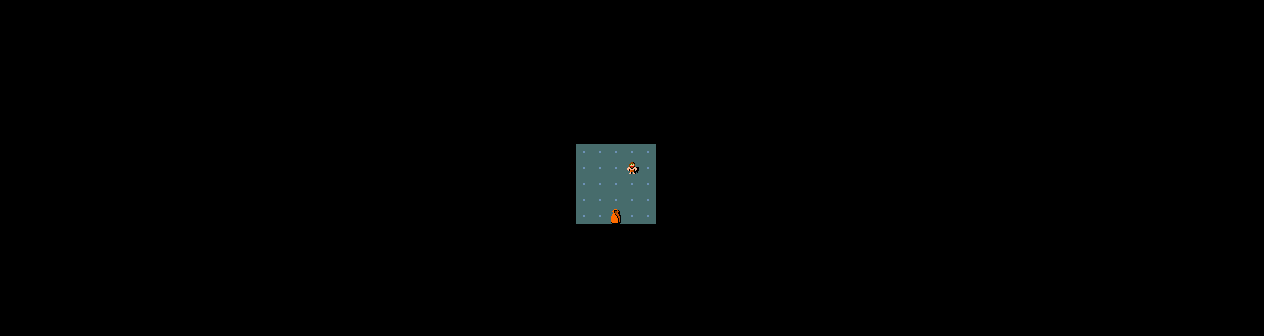

In [150]:
# For the Wear environment the agent also needs to be able to pickup an item, 
# choose to wear it and confirm that they want to wear 
MOVE_ACTIONS = tuple(nethack.CompassDirection)
WEAR_ACTIONS = MOVE_ACTIONS + (nethack.Command.PICKUP, nethack.Command.WEAR, nethack.Command.FIRE,)

# Much more complicated than any of the previous tasks so the episode length has to be increased to 10000
env = gym.make("MiniHack-Wear-v0", observation_keys=["glyphs","pixel","message"], 
               actions = WEAR_ACTIONS, max_episode_steps=10000)

# Reset the environment and display the screen of the starting state 
display_screen(env.reset())

In [157]:
wear_scores = run_actor_critic(env,number_episodes=100,max_episode_length=1000,iterations=5)

Episode: 0 Reward: -8.04 Average Reward: -8.04 Steps 999


/opt/homebrew/Caskroom/miniforge/base/envs/minihack/lib/python3.9/site-packages/torch/_tensor.py:493: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Episode: 1 Reward: -9.969999999999999 Average Reward: -9.004999999999999 Steps 999
Episode: 2 Reward: -6.98 Average Reward: -8.33 Steps 999
Episode: 3 Reward: -8.51 Average Reward: -8.375 Steps 999
Episode: 4 Reward: -9.5 Average Reward: -8.6 Steps 999
Episode: 5 Reward: -9.219999999999999 Average Reward: -8.703333333333333 Steps 999
Episode: 6 Reward: 0.22999999999999998 Average Reward: -7.427142857142857 Steps 210
Episode: 7 Reward: 0.31999999999999995 Average Reward: -6.45875 Steps 153
Episode: 8 Reward: -0.07000000000000006 Average Reward: -5.748888888888889 Steps 226
Episode: 9 Reward: -7.1899999999999995 Average Reward: -5.893 Steps 999
Episode: 10 Reward: 0.62 Average Reward: -5.300909090909091 Steps 69
Episode: 11 Reward: -7.969999999999999 Average Reward: -5.523333333333333 Steps 999
Episode: 12 Reward: -8.09 Average Reward: -5.720769230769231 Steps 999
Episode: 13 Reward: -7.2 Average Reward: -5.826428571428572 Steps 999
Episode: 14 Reward: -4.43 Average Reward: -5.7333333333

KeyboardInterrupt: 

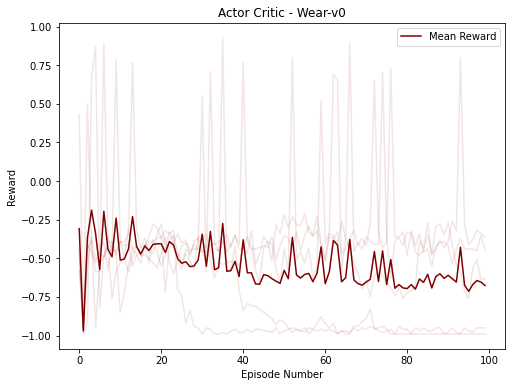

In [156]:
plot_results(env_name="Wear-v0",scores=wear_scores, color = "maroon" )

## 2.3 Skill Acquisition - Lava Cross Potion Inv

## 3. Quest Hard 

## 3.1. Quest-Hard With Pray

In [54]:
QUEST_ACTIONS_1 = (
    nethack.CompassDirection.N,
    nethack.CompassDirection.E,
    nethack.CompassDirection.S,
    nethack.CompassDirection.W,
    nethack.CompassDirection.NW,
    nethack.Command.PICKUP,
    nethack.Command.APPLY,
    nethack.Command.FIRE,
    nethack.Command.RUSH,
    nethack.Command.ZAP, 
    nethack.Command.PUTON,
    nethack.Command.READ,
    nethack.Command.WEAR,
    nethack.Command.QUAFF,
    nethack.Command.PRAY
)

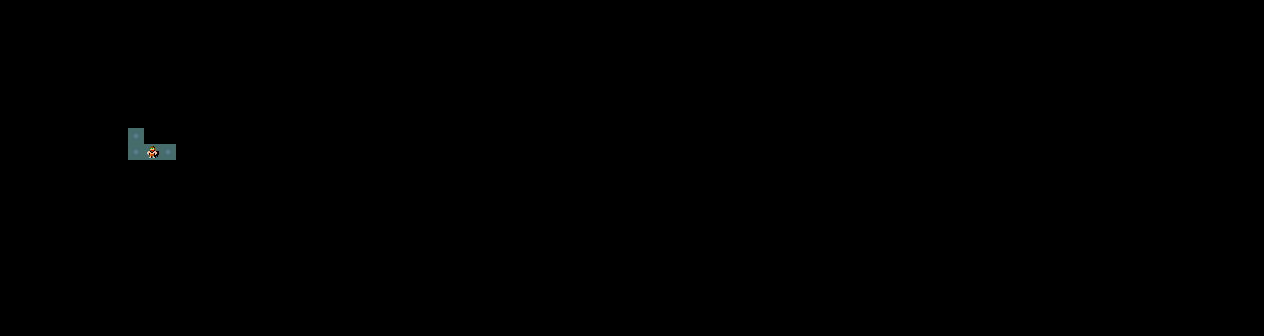

In [55]:
env = gym.make("MiniHack-Quest-Hard-v0", actions = QUEST_ACTIONS_1, observation_keys=["glyphs","pixel","message"])
display_screen(env.reset())

In [56]:
quest_hard_pray_scores = run_actor_critic(env, number_episodes = 150, max_episode_length = 1000,iterations = 5)

Episode: 0 Reward: -0.9999999999999999 Average Reward: -0.9999999999999999 Steps 117


/tmp/ipykernel_30699/61882409.py:83: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.smooth_l1_loss(value, reward)


Episode: 1 Reward: -9.889999999999999 Average Reward: -5.444999999999999 Steps 999
Episode: 2 Reward: -0.16000000000000003 Average Reward: -3.683333333333333 Steps 21
Episode: 3 Reward: -3.6799999999999997 Average Reward: -3.6824999999999997 Steps 372
Episode: 4 Reward: -1.21 Average Reward: -3.1879999999999997 Steps 124
Episode: 5 Reward: -0.5800000000000001 Average Reward: -2.7533333333333325 Steps 61
Episode: 6 Reward: -0.54 Average Reward: -2.4371428571428564 Steps 63
Episode: 7 Reward: -0.95 Average Reward: -2.2512499999999998 Steps 99
Episode: 8 Reward: -0.8799999999999999 Average Reward: -2.0988888888888884 Steps 94
Episode: 9 Reward: -1.0799999999999998 Average Reward: -1.9969999999999994 Steps 120
Episode: 10 Reward: -0.2800000000000001 Average Reward: -1.8409090909090906 Steps 39
Episode: 11 Reward: -0.45000000000000007 Average Reward: -1.7249999999999996 Steps 50
Episode: 12 Reward: -0.21000000000000002 Average Reward: -1.6084615384615382 Steps 28
Episode: 13 Reward: -0.09 A

Episode: 113 Reward: -0.07 Average Reward: -0.0754 Steps 11
Episode: 114 Reward: -0.04 Average Reward: -0.0754 Steps 7
Episode: 115 Reward: -0.060000000000000005 Average Reward: -0.0754 Steps 10
Episode: 116 Reward: -0.05 Average Reward: -0.0754 Steps 8
Episode: 117 Reward: -0.05 Average Reward: -0.0754 Steps 8
Episode: 118 Reward: -0.04 Average Reward: -0.0722 Steps 8
Episode: 119 Reward: -0.03 Average Reward: -0.07219999999999999 Steps 5
Episode: 120 Reward: -0.03 Average Reward: -0.0702 Steps 6
Episode: 121 Reward: -0.05 Average Reward: -0.06919999999999998 Steps 8
Episode: 122 Reward: -0.09 Average Reward: -0.0642 Steps 15
Episode: 123 Reward: -0.03 Average Reward: -0.06299999999999999 Steps 5
Episode: 124 Reward: -0.02 Average Reward: -0.0616 Steps 4
Episode: 125 Reward: -0.03 Average Reward: -0.05959999999999999 Steps 5
Episode: 126 Reward: -0.04 Average Reward: -0.0596 Steps 7
Episode: 127 Reward: -0.04 Average Reward: -0.0584 Steps 8
Episode: 128 Reward: -0.08 Average Reward: -

Episode: 75 Reward: -0.13 Average Reward: -0.24280000000000004 Steps 19
Episode: 76 Reward: -0.09 Average Reward: -0.23440000000000005 Steps 12
Episode: 77 Reward: -0.26 Average Reward: -0.22980000000000003 Steps 33
Episode: 78 Reward: -0.24000000000000002 Average Reward: -0.21380000000000002 Steps 27
Episode: 79 Reward: -0.5700000000000001 Average Reward: -0.2094 Steps 64
Episode: 80 Reward: -0.44000000000000006 Average Reward: -0.20559999999999998 Steps 47
Episode: 81 Reward: -0.53 Average Reward: -0.21420000000000003 Steps 58
Episode: 82 Reward: -0.5700000000000001 Average Reward: -0.2202 Steps 65
Episode: 83 Reward: -0.33000000000000007 Average Reward: -0.21720000000000003 Steps 38
Episode: 84 Reward: -0.15000000000000002 Average Reward: -0.2088 Steps 19
Episode: 85 Reward: -0.11 Average Reward: -0.20680000000000004 Steps 18
Episode: 86 Reward: -0.09 Average Reward: -0.2072 Steps 12
Episode: 87 Reward: -0.06999999999999999 Average Reward: -0.20520000000000002 Steps 10
Episode: 88 R

Episode: 38 Reward: -0.79 Average Reward: -2.662307692307693 Steps 93
Episode: 39 Reward: -0.32 Average Reward: -2.60375 Steps 40
Episode: 40 Reward: -0.8199999999999998 Average Reward: -2.560243902439024 Steps 97
Episode: 41 Reward: -0.4700000000000001 Average Reward: -2.51047619047619 Steps 55
Episode: 42 Reward: -0.73 Average Reward: -2.46906976744186 Steps 81
Episode: 43 Reward: -0.54 Average Reward: -2.425227272727273 Steps 61
Episode: 44 Reward: -0.6200000000000001 Average Reward: -2.385111111111111 Steps 69
Episode: 45 Reward: -0.2700000000000001 Average Reward: -2.3391304347826085 Steps 31
Episode: 46 Reward: -1.7099999999999997 Average Reward: -2.325744680851064 Steps 201
Episode: 47 Reward: -0.4 Average Reward: -2.2856249999999996 Steps 49
Episode: 48 Reward: -0.72 Average Reward: -2.2536734693877545 Steps 82
Episode: 49 Reward: -0.76 Average Reward: -2.2237999999999998 Steps 86
Episode: 50 Reward: -0.66 Average Reward: -2.2186 Steps 74
Episode: 51 Reward: -0.5800000000000001

Episode: 0 Reward: -0.81 Average Reward: -0.81 Steps 95
Episode: 1 Reward: -9.989999999999998 Average Reward: -5.3999999999999995 Steps 999
Episode: 2 Reward: -4.87 Average Reward: -5.223333333333333 Steps 533
Episode: 3 Reward: -0.39 Average Reward: -4.015 Steps 45
Episode: 4 Reward: -0.69 Average Reward: -3.35 Steps 81
Episode: 5 Reward: -9.989999999999998 Average Reward: -4.456666666666666 Steps 999
Episode: 6 Reward: -0.6200000000000001 Average Reward: -3.9085714285714284 Steps 74
Episode: 7 Reward: -0.8599999999999999 Average Reward: -3.5275 Steps 99
Episode: 8 Reward: -0.2700000000000001 Average Reward: -3.1655555555555552 Steps 31
Episode: 9 Reward: -0.09999999999999999 Average Reward: -2.859 Steps 12
Episode: 10 Reward: -0.13 Average Reward: -2.610909090909091 Steps 16
Episode: 11 Reward: -0.4600000000000001 Average Reward: -2.4316666666666666 Steps 50
Episode: 12 Reward: -0.6200000000000001 Average Reward: -2.292307692307692 Steps 72
Episode: 13 Reward: -0.07 Average Reward: -

Episode: 111 Reward: -0.04 Average Reward: -0.11500000000000002 Steps 8
Episode: 112 Reward: -0.02 Average Reward: -0.1146 Steps 4
Episode: 113 Reward: -0.03 Average Reward: -0.1142 Steps 8
Episode: 114 Reward: -0.09 Average Reward: -0.11259999999999999 Steps 11
Episode: 115 Reward: -0.17 Average Reward: -0.115 Steps 24
Episode: 116 Reward: -0.04 Average Reward: -0.1108 Steps 7
Episode: 117 Reward: -0.03 Average Reward: -0.11020000000000002 Steps 5
Episode: 118 Reward: -0.03 Average Reward: -0.10980000000000001 Steps 5
Episode: 119 Reward: -0.13 Average Reward: -0.10800000000000001 Steps 19
Episode: 120 Reward: -0.06999999999999999 Average Reward: -0.10880000000000001 Steps 11
Episode: 121 Reward: -0.05 Average Reward: -0.106 Steps 8
Episode: 122 Reward: -0.11999999999999998 Average Reward: -0.10739999999999998 Steps 23
Episode: 123 Reward: -0.05 Average Reward: -0.1048 Steps 8
Episode: 124 Reward: -0.14 Average Reward: -0.10379999999999999 Steps 18
Episode: 125 Reward: -0.13 Average R

Episode: 77 Reward: -0.05 Average Reward: -0.42779999999999996 Steps 8
Episode: 78 Reward: -0.08999999999999998 Average Reward: -0.40700000000000003 Steps 13
Episode: 79 Reward: -0.05 Average Reward: -0.3922 Steps 8
Episode: 80 Reward: -0.11 Average Reward: -0.37800000000000006 Steps 16
Episode: 81 Reward: -0.03 Average Reward: -0.374 Steps 6
Episode: 82 Reward: -0.05 Average Reward: -0.3492 Steps 10
Episode: 83 Reward: -0.04 Average Reward: -0.3356 Steps 7
Episode: 84 Reward: -0.09 Average Reward: -0.28800000000000003 Steps 14
Episode: 85 Reward: -0.04 Average Reward: -0.2692 Steps 7
Episode: 86 Reward: -0.05 Average Reward: -0.26220000000000004 Steps 10
Episode: 87 Reward: -0.05 Average Reward: -0.24640000000000004 Steps 8
Episode: 88 Reward: -0.03 Average Reward: -0.23300000000000004 Steps 5
Episode: 89 Reward: -0.04 Average Reward: -0.22419999999999998 Steps 6
Episode: 90 Reward: -0.060000000000000005 Average Reward: -0.21660000000000004 Steps 11
Episode: 91 Reward: -0.02 Average R

In [36]:
plot_results(env_name="Quest-Hard-v0-pray",scores=quest_hard_pray_scores, color = "teal" )

NameError: name 'quest_hard_pray_scores' is not defined

In [63]:
# import csv

# with open('quest_hard_pray.csv', 'w') as f:
#     write = csv.writer(f) 
#     for score in quest_hard_pray_scores:
#         write.writerow(score) 

## 3.1. Quest-Hard Explore

The previous model included the pray option and found it could pray continously and die early to recieve less negative rewards that may come when exploring. The pray action is then removed for the next experiment. Other reward shaping techniques are also added to encourage exploration.

In [3]:
QUEST_ACTIONS_2 = (
    nethack.CompassDirection.N,
    nethack.CompassDirection.E,
    nethack.CompassDirection.S,
    nethack.CompassDirection.W,
    nethack.CompassDirection.NW,
    nethack.Command.PICKUP,
    nethack.Command.APPLY,
    nethack.Command.FIRE,
    nethack.Command.RUSH,
    nethack.Command.ZAP, 
    nethack.Command.PUTON,
    nethack.Command.READ,
    nethack.Command.WEAR,
    nethack.Command.QUAFF
)

In [5]:
def maze_explore_reward(env, prev_obs, action, next_obs):
    if (prev_obs[0] == 2359).sum() > (next_obs[0] == 2359).sum():
        return 0.1
    return 0

In [6]:
from minihack import RewardManager

reward_gen = RewardManager()
reward_gen.add_eat_event("apple", reward=1)
reward_gen.add_coordinate_event((3,27), reward = -5, terminal_required = False)
reward_gen.add_coordinate_event((3,28), reward = -5, terminal_required = False)
reward_gen.add_coordinate_event((3,29), reward = -5, terminal_required = False)

reward_gen.add_coordinate_event((19,27), reward = -5, terminal_required = False)
reward_gen.add_coordinate_event((19,28), reward = -5, terminal_required = False)
reward_gen.add_coordinate_event((19,29), reward = -5, terminal_required = False)

reward_gen.add_coordinate_event((11,27), reward = 100, terminal_required = False)# first door at end of maze
reward_gen.add_custom_reward_fn(maze_explore_reward)

In [32]:
env = gym.make("MiniHack-Quest-Hard-v0", reward_manager = reward_gen, actions = QUEST_ACTIONS_2)

quest_hard_exp_scores = run_actor_critic(env, number_episodes = 500, max_episode_length = 1000,iterations = 5)

Episode: 0 Reward: -7.459999999999999 Average Reward: -7.459999999999999 Steps 999


/home/thishen/.local/lib/python3.8/site-packages/torch/tensor.py:447: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/tmp/ipykernel_2817/61882409.py:83: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.smooth_l1_loss(value, reward)


Episode: 1 Reward: -9.989999999999998 Average Reward: -8.724999999999998 Steps 999
Episode: 2 Reward: -5.35 Average Reward: -7.599999999999999 Steps 999
Episode: 3 Reward: -8.87 Average Reward: -7.917499999999999 Steps 999
Episode: 4 Reward: -9.989999999999998 Average Reward: -8.331999999999999 Steps 999
Episode: 5 Reward: -7.609999999999999 Average Reward: -8.211666666666666 Steps 999
Episode: 6 Reward: -5.72 Average Reward: -7.855714285714285 Steps 999
Episode: 7 Reward: -6.219999999999999 Average Reward: -7.651249999999999 Steps 999
Episode: 8 Reward: -6.92 Average Reward: -7.569999999999999 Steps 999
Episode: 9 Reward: -6.359999999999999 Average Reward: -7.449 Steps 999
Episode: 10 Reward: -7.509999999999999 Average Reward: -7.454545454545454 Steps 999
Episode: 11 Reward: -7.739999999999998 Average Reward: -7.478333333333333 Steps 999
Episode: 12 Reward: -6.819999999999999 Average Reward: -7.427692307692307 Steps 999
Episode: 13 Reward: -6.249999999999999 Average Reward: -7.3435714

Episode: 109 Reward: -4.16 Average Reward: -5.0648 Steps 999
Episode: 110 Reward: -4.43 Average Reward: -5.091599999999999 Steps 999
Episode: 111 Reward: -4.68 Average Reward: -5.0624 Steps 999
Episode: 112 Reward: -3.33 Average Reward: -5.032 Steps 999
Episode: 113 Reward: -6.84 Average Reward: -5.0288 Steps 999
Episode: 114 Reward: -4.06 Average Reward: -5.0044 Steps 999
Episode: 115 Reward: -1.0899999999999996 Average Reward: -4.889399999999999 Steps 999
Episode: 116 Reward: -4.67 Average Reward: -4.849799999999999 Steps 999
Episode: 117 Reward: -2.5999999999999996 Average Reward: -4.801399999999998 Steps 999
Episode: 118 Reward: -2.59 Average Reward: -4.7394 Steps 999
Episode: 119 Reward: -4.609999999999999 Average Reward: -4.729399999999999 Steps 999
Episode: 120 Reward: -5.1899999999999995 Average Reward: -4.72 Steps 999
Episode: 121 Reward: -3.8099999999999996 Average Reward: -4.6704 Steps 999
Episode: 122 Reward: -3.6399999999999997 Average Reward: -4.642199999999999 Steps 999


Episode: 225 Reward: -3.4699999999999998 Average Reward: -3.5426000000000006 Steps 999
Episode: 226 Reward: -3.73 Average Reward: -3.517 Steps 999
Episode: 227 Reward: -3.0999999999999996 Average Reward: -3.4730000000000003 Steps 999
Episode: 228 Reward: -3.53 Average Reward: -3.4494000000000007 Steps 999
Episode: 229 Reward: -6.109999999999999 Average Reward: -3.4720000000000004 Steps 999
Episode: 230 Reward: -2.55 Average Reward: -3.429 Steps 999
Episode: 231 Reward: -3.5699999999999994 Average Reward: -3.4008000000000003 Steps 999
Episode: 232 Reward: -2.93 Average Reward: -3.3888 Steps 999
Episode: 233 Reward: -3.0 Average Reward: -3.4158000000000004 Steps 999
Episode: 234 Reward: -1.67 Average Reward: -3.3637999999999995 Steps 999
Episode: 235 Reward: -4.42 Average Reward: -3.3585999999999996 Steps 999
Episode: 236 Reward: -2.38 Average Reward: -3.3522 Steps 999
Episode: 237 Reward: -3.1799999999999997 Average Reward: -3.3276 Steps 999
Episode: 238 Reward: -2.41 Average Reward: -3

Episode: 339 Reward: -4.119999999999999 Average Reward: -2.9684 Steps 999
Episode: 340 Reward: -3.99 Average Reward: -2.9951999999999996 Steps 999
Episode: 341 Reward: -3.3499999999999996 Average Reward: -2.9944 Steps 999
Episode: 342 Reward: -3.9000000000000004 Average Reward: -3.0134 Steps 999
Episode: 343 Reward: -0.5599999999999999 Average Reward: -2.9416 Steps 999
Episode: 344 Reward: -1.43 Average Reward: -2.9128000000000003 Steps 999
Episode: 345 Reward: -1.44 Average Reward: -2.8646000000000003 Steps 999
Episode: 346 Reward: -3.2600000000000002 Average Reward: -2.8705999999999996 Steps 999
Episode: 347 Reward: -2.6099999999999994 Average Reward: -2.8779999999999997 Steps 999
Episode: 348 Reward: -1.5300000000000002 Average Reward: -2.8594 Steps 999
Episode: 349 Reward: -3.82 Average Reward: -2.8694 Steps 999
Episode: 350 Reward: -4.33 Average Reward: -2.9112000000000005 Steps 999
Episode: 351 Reward: -2.1199999999999997 Average Reward: -2.8828000000000005 Steps 999
Episode: 352

Episode: 449 Reward: -1.25 Average Reward: -3.025 Steps 999
Episode: 450 Reward: -4.15 Average Reward: -3.0286 Steps 999
Episode: 451 Reward: -4.609999999999999 Average Reward: -3.0646000000000004 Steps 999
Episode: 452 Reward: -4.18 Average Reward: -3.085200000000001 Steps 999
Episode: 453 Reward: -3.19 Average Reward: -3.0852 Steps 999
Episode: 454 Reward: -1.7800000000000002 Average Reward: -3.0614000000000003 Steps 999
Episode: 455 Reward: -4.459999999999999 Average Reward: -3.0894 Steps 999
Episode: 456 Reward: 0.74 Average Reward: -3.0562 Steps 999
Episode: 457 Reward: -2.87 Average Reward: -3.0574 Steps 999
Episode: 458 Reward: -3.69 Average Reward: -3.0492000000000004 Steps 999
Episode: 459 Reward: -2.1000000000000005 Average Reward: -3.0213999999999994 Steps 999
Episode: 460 Reward: -4.01 Average Reward: -3.0233999999999996 Steps 999
Episode: 461 Reward: -3.02 Average Reward: -3.0206 Steps 999
Episode: 462 Reward: -2.57 Average Reward: -3.0012 Steps 999
Episode: 463 Reward: -2

Episode: 61 Reward: -4.81 Average Reward: -5.1876 Steps 999
Episode: 62 Reward: -6.029999999999999 Average Reward: -5.180599999999999 Steps 999
Episode: 63 Reward: -5.54 Average Reward: -5.1636 Steps 999
Episode: 64 Reward: -4.949999999999999 Average Reward: -5.1518 Steps 999
Episode: 65 Reward: -4.9399999999999995 Average Reward: -5.134399999999999 Steps 999
Episode: 66 Reward: -5.85 Average Reward: -5.129 Steps 999
Episode: 67 Reward: -3.8099999999999996 Average Reward: -5.084199999999999 Steps 999
Episode: 68 Reward: -3.42 Average Reward: -5.0428 Steps 999
Episode: 69 Reward: -2.86 Average Reward: -4.9342 Steps 999
Episode: 70 Reward: -5.989999999999999 Average Reward: -4.9398 Steps 999
Episode: 71 Reward: -3.7300000000000004 Average Reward: -4.8942 Steps 999
Episode: 72 Reward: -5.4799999999999995 Average Reward: -4.954999999999999 Steps 999
Episode: 73 Reward: -3.6599999999999997 Average Reward: -4.905799999999999 Steps 999
Episode: 74 Reward: -5.109999999999999 Average Reward: -4

Episode: 175 Reward: -3.1100000000000003 Average Reward: -4.446200000000001 Steps 999
Episode: 176 Reward: -3.6899999999999995 Average Reward: -4.4182 Steps 999
Episode: 177 Reward: -4.62 Average Reward: -4.4348 Steps 999
Episode: 178 Reward: -3.4399999999999995 Average Reward: -4.4246 Steps 999
Episode: 179 Reward: -4.620000000000001 Average Reward: -4.4062 Steps 999
Episode: 180 Reward: -1.4899999999999998 Average Reward: -4.3164 Steps 999
Episode: 181 Reward: -3.3099999999999996 Average Reward: -4.285399999999999 Steps 999
Episode: 182 Reward: -4.119999999999999 Average Reward: -4.2936000000000005 Steps 999
Episode: 183 Reward: -3.59 Average Reward: -4.2836 Steps 999
Episode: 184 Reward: -3.05 Average Reward: -4.2282 Steps 999
Episode: 185 Reward: -3.34 Average Reward: -4.1948 Steps 999
Episode: 186 Reward: -5.909999999999999 Average Reward: -4.2142 Steps 999
Episode: 187 Reward: -3.95 Average Reward: -4.2059999999999995 Steps 999
Episode: 188 Reward: -5.219999999999999 Average Rewa

Episode: 289 Reward: -3.4599999999999995 Average Reward: -3.3680000000000008 Steps 999
Episode: 290 Reward: -5.529999999999999 Average Reward: -3.5056 Steps 999
Episode: 291 Reward: -4.9399999999999995 Average Reward: -3.557 Steps 999
Episode: 292 Reward: -3.92 Average Reward: -3.5334 Steps 999
Episode: 293 Reward: -6.93 Average Reward: -3.5144 Steps 999
Episode: 294 Reward: -2.3000000000000003 Average Reward: -3.5028 Steps 999
Episode: 295 Reward: -4.64 Average Reward: -3.4928 Steps 999
Episode: 296 Reward: -4.04 Average Reward: -3.4671999999999996 Steps 999
Episode: 297 Reward: -2.6500000000000004 Average Reward: -3.4452 Steps 999
Episode: 298 Reward: -4.86 Average Reward: -3.4526000000000003 Steps 999
Episode: 299 Reward: -3.29 Average Reward: -3.4444 Steps 999
Episode: 300 Reward: -3.4499999999999997 Average Reward: -3.4323999999999995 Steps 999
Episode: 301 Reward: -5.549999999999999 Average Reward: -3.4424 Steps 999
Episode: 302 Reward: -0.9400000000000005 Average Reward: -3.3798

Episode: 402 Reward: -4.3100000000000005 Average Reward: -3.7207999999999997 Steps 999
Episode: 403 Reward: -2.6100000000000003 Average Reward: -3.6660000000000004 Steps 999
Episode: 404 Reward: -3.37 Average Reward: -3.6614 Steps 999
Episode: 405 Reward: -1.2300000000000002 Average Reward: -3.5980000000000003 Steps 999
Episode: 406 Reward: -3.66 Average Reward: -3.6113999999999997 Steps 999
Episode: 407 Reward: -3.1799999999999997 Average Reward: -3.6126000000000005 Steps 999
Episode: 408 Reward: -2.75 Average Reward: -3.5326 Steps 999
Episode: 409 Reward: -2.8200000000000003 Average Reward: -3.4956 Steps 999
Episode: 410 Reward: -2.0999999999999996 Average Reward: -3.4532 Steps 999
Episode: 411 Reward: -1.7299999999999998 Average Reward: -3.3914 Steps 999
Episode: 412 Reward: -3.2800000000000002 Average Reward: -3.4095999999999997 Steps 999
Episode: 413 Reward: -2.14 Average Reward: -3.3756 Steps 999
Episode: 414 Reward: -3.1599999999999997 Average Reward: -3.3737999999999992 Steps 9

Episode: 11 Reward: -8.45 Average Reward: -8.795833333333333 Steps 999
Episode: 12 Reward: -9.57 Average Reward: -8.855384615384613 Steps 999
Episode: 13 Reward: -7.91 Average Reward: -8.78785714285714 Steps 999
Episode: 14 Reward: -9.219999999999999 Average Reward: -8.816666666666665 Steps 999
Episode: 15 Reward: -8.95 Average Reward: -8.825 Steps 999
Episode: 16 Reward: -7.4 Average Reward: -8.741176470588234 Steps 999
Episode: 17 Reward: -9.04 Average Reward: -8.757777777777777 Steps 999
Episode: 18 Reward: -7.139999999999999 Average Reward: -8.672631578947367 Steps 999
Episode: 19 Reward: -9.129999999999999 Average Reward: -8.6955 Steps 999
Episode: 20 Reward: -8.95 Average Reward: -8.707619047619046 Steps 999
Episode: 21 Reward: -6.789999999999999 Average Reward: -8.620454545454542 Steps 999
Episode: 22 Reward: -7.66 Average Reward: -8.578695652173911 Steps 999
Episode: 23 Reward: -7.339999999999999 Average Reward: -8.527083333333332 Steps 999
Episode: 24 Reward: -7.31999999999999

Episode: 121 Reward: -3.53 Average Reward: -4.865 Steps 999
Episode: 122 Reward: -4.04 Average Reward: -4.844799999999999 Steps 999
Episode: 123 Reward: -4.46 Average Reward: -4.7384 Steps 999
Episode: 124 Reward: -3.58 Average Reward: -4.687799999999999 Steps 999
Episode: 125 Reward: -3.12 Average Reward: -4.6692 Steps 999
Episode: 126 Reward: -2.0 Average Reward: -4.6348 Steps 999
Episode: 127 Reward: -1.2999999999999998 Average Reward: -4.5528 Steps 999
Episode: 128 Reward: -4.72 Average Reward: -4.5494 Steps 999
Episode: 129 Reward: -4.56 Average Reward: -4.558599999999999 Steps 999
Episode: 130 Reward: -3.4 Average Reward: -4.5076 Steps 999
Episode: 131 Reward: -3.5799999999999996 Average Reward: -4.450400000000001 Steps 999
Episode: 132 Reward: -4.54 Average Reward: -4.343999999999999 Steps 999
Episode: 133 Reward: -3.12 Average Reward: -4.273599999999999 Steps 999
Episode: 134 Reward: -2.67 Average Reward: -4.1758 Steps 999
Episode: 135 Reward: -1.4 Average Reward: -4.0604 Steps

Episode: 234 Reward: -2.34 Average Reward: -3.461 Steps 999
Episode: 235 Reward: -4.13 Average Reward: -3.4613999999999994 Steps 999
Episode: 236 Reward: -4.33 Average Reward: -3.4663999999999997 Steps 999
Episode: 237 Reward: -0.5800000000000003 Average Reward: -3.3968000000000007 Steps 999
Episode: 238 Reward: -0.9100000000000001 Average Reward: -3.414399999999999 Steps 999
Episode: 239 Reward: -2.4099999999999997 Average Reward: -3.284 Steps 999
Episode: 240 Reward: -3.7 Average Reward: -3.2801999999999993 Steps 999
Episode: 241 Reward: -7.42 Average Reward: -3.3819999999999997 Steps 999
Episode: 242 Reward: -2.23 Average Reward: -3.363599999999999 Steps 999
Episode: 243 Reward: -3.9899999999999998 Average Reward: -3.4271999999999996 Steps 999
Episode: 244 Reward: -3.51 Average Reward: -3.4848000000000003 Steps 999
Episode: 245 Reward: -4.279999999999999 Average Reward: -3.5044 Steps 999
Episode: 246 Reward: -3.55 Average Reward: -3.5596000000000005 Steps 999
Episode: 247 Reward: -3

Episode: 345 Reward: -3.84 Average Reward: -3.3755999999999995 Steps 999
Episode: 346 Reward: -2.38 Average Reward: -3.3562 Steps 999
Episode: 347 Reward: -4.58 Average Reward: -3.3588000000000005 Steps 999
Episode: 348 Reward: -4.61 Average Reward: -3.3896 Steps 999
Episode: 349 Reward: -3.5 Average Reward: -3.3820000000000006 Steps 999
Episode: 350 Reward: -1.9100000000000001 Average Reward: -3.375 Steps 999
Episode: 351 Reward: -2.3499999999999996 Average Reward: -3.3684000000000003 Steps 999
Episode: 352 Reward: -3.0300000000000002 Average Reward: -3.3386 Steps 999
Episode: 353 Reward: -2.9 Average Reward: -3.3054 Steps 999
Episode: 354 Reward: -4.26 Average Reward: -3.3352 Steps 999
Episode: 355 Reward: -1.2599999999999998 Average Reward: -3.2753999999999994 Steps 999
Episode: 356 Reward: -2.83 Average Reward: -3.2344 Steps 999
Episode: 357 Reward: -3.1900000000000004 Average Reward: -3.2182 Steps 999
Episode: 358 Reward: -1.4 Average Reward: -3.1799999999999993 Steps 999
Episode:

Episode: 457 Reward: -2.75 Average Reward: -2.2228 Steps 999
Episode: 458 Reward: -4.3 Average Reward: -2.259 Steps 999
Episode: 459 Reward: -2.25 Average Reward: -2.2725999999999997 Steps 999
Episode: 460 Reward: -2.6799999999999997 Average Reward: -2.19 Steps 999
Episode: 461 Reward: -1.9699999999999998 Average Reward: -2.1756 Steps 999
Episode: 462 Reward: -1.9100000000000001 Average Reward: -2.1795999999999998 Steps 999
Episode: 463 Reward: -4.2 Average Reward: -2.2011999999999996 Steps 999
Episode: 464 Reward: -0.5400000000000005 Average Reward: -2.2004 Steps 999
Episode: 465 Reward: -1.36 Average Reward: -2.1526 Steps 999
Episode: 466 Reward: -2.5000000000000004 Average Reward: -2.1172 Steps 999
Episode: 467 Reward: -1.5899999999999999 Average Reward: -2.135 Steps 999
Episode: 468 Reward: -3.48 Average Reward: -2.1546000000000003 Steps 999
Episode: 469 Reward: -1.0400000000000003 Average Reward: -2.1488 Steps 999
Episode: 470 Reward: -0.7300000000000004 Average Reward: -2.2037999

Episode: 67 Reward: -3.72 Average Reward: -4.657999999999999 Steps 999
Episode: 68 Reward: -3.81 Average Reward: -4.6156 Steps 999
Episode: 69 Reward: -2.5899999999999994 Average Reward: -4.541399999999999 Steps 999
Episode: 70 Reward: -5.779999999999999 Average Reward: -4.565 Steps 999
Episode: 71 Reward: -2.9599999999999995 Average Reward: -4.526 Steps 999
Episode: 72 Reward: -3.46 Average Reward: -4.4916 Steps 999
Episode: 73 Reward: -3.3999999999999995 Average Reward: -4.4468 Steps 999
Episode: 74 Reward: -3.5599999999999996 Average Reward: -4.4156 Steps 999
Episode: 75 Reward: -4.79 Average Reward: -4.3918 Steps 999
Episode: 76 Reward: -4.3999999999999995 Average Reward: -4.3576 Steps 999
Episode: 77 Reward: -3.5799999999999996 Average Reward: -4.3014 Steps 999
Episode: 78 Reward: -1.6299999999999994 Average Reward: -4.220000000000001 Steps 999
Episode: 79 Reward: -3.98 Average Reward: -4.210799999999999 Steps 999
Episode: 80 Reward: -2.2300000000000004 Average Reward: -4.1724 Ste

Episode: 180 Reward: -2.84 Average Reward: -2.5465999999999998 Steps 999
Episode: 181 Reward: -4.49 Average Reward: -2.5848 Steps 999
Episode: 182 Reward: -3.7399999999999993 Average Reward: -2.7116000000000002 Steps 999
Episode: 183 Reward: -3.54 Average Reward: -2.7421999999999995 Steps 999
Episode: 184 Reward: -3.48 Average Reward: -2.7845999999999993 Steps 999
Episode: 185 Reward: -2.44 Average Reward: -2.7878 Steps 999
Episode: 186 Reward: -1.67 Average Reward: -2.727 Steps 999
Episode: 187 Reward: -1.5399999999999996 Average Reward: -2.734 Steps 999
Episode: 188 Reward: -0.8800000000000001 Average Reward: -2.7014 Steps 999
Episode: 189 Reward: -3.3300000000000005 Average Reward: -2.7186000000000003 Steps 999
Episode: 190 Reward: -0.7599999999999998 Average Reward: -2.6684 Steps 999
Episode: 191 Reward: -1.2400000000000002 Average Reward: -2.6141999999999994 Steps 999
Episode: 192 Reward: -1.17 Average Reward: -2.6234 Steps 999
Episode: 193 Reward: -3.0600000000000005 Average Rewa

Episode: 293 Reward: -2.87 Average Reward: -2.1526 Steps 999
Episode: 294 Reward: -2.12 Average Reward: -2.1612 Steps 999
Episode: 295 Reward: -2.2 Average Reward: -2.1910000000000003 Steps 999
Episode: 296 Reward: -3.0700000000000003 Average Reward: -2.1786000000000003 Steps 999
Episode: 297 Reward: -1.6400000000000003 Average Reward: -2.2074 Steps 999
Episode: 298 Reward: 1.08 Average Reward: -2.151 Steps 999
Episode: 299 Reward: -3.86 Average Reward: -2.2438 Steps 999
Episode: 300 Reward: -2.2399999999999998 Average Reward: -2.2672 Steps 999
Episode: 301 Reward: -4.21 Average Reward: -2.3031999999999995 Steps 999
Episode: 302 Reward: -2.54 Average Reward: -2.296 Steps 999
Episode: 303 Reward: -2.37 Average Reward: -2.3078 Steps 999
Episode: 304 Reward: -3.2600000000000002 Average Reward: -2.3404 Steps 999
Episode: 305 Reward: -2.0500000000000003 Average Reward: -2.3356 Steps 999
Episode: 306 Reward: -7.6 Average Reward: -2.4072 Steps 999
Episode: 307 Reward: -0.74 Average Reward: -2

Episode: 409 Reward: -3.4999999999999996 Average Reward: -2.2208 Steps 999
Episode: 410 Reward: -3.46 Average Reward: -2.2556 Steps 999
Episode: 411 Reward: -3.25 Average Reward: -2.2953999999999994 Steps 999
Episode: 412 Reward: -2.71 Average Reward: -2.2669999999999995 Steps 999
Episode: 413 Reward: -2.5700000000000003 Average Reward: -2.2615999999999996 Steps 999
Episode: 414 Reward: -1.33 Average Reward: -2.203 Steps 999
Episode: 415 Reward: -2.6 Average Reward: -2.1739999999999995 Steps 999
Episode: 416 Reward: 1.0600000000000003 Average Reward: -2.1659999999999995 Steps 999
Episode: 417 Reward: -2.9699999999999998 Average Reward: -2.089 Steps 999
Episode: 418 Reward: -2.5100000000000002 Average Reward: -2.0744 Steps 999
Episode: 419 Reward: -3.1799999999999997 Average Reward: -2.1174 Steps 999
Episode: 420 Reward: -4.54 Average Reward: -2.1700000000000004 Steps 999
Episode: 421 Reward: -3.67 Average Reward: -2.189 Steps 999
Episode: 422 Reward: -1.5199999999999998 Average Reward:

Episode: 18 Reward: -7.189999999999999 Average Reward: -7.247894736842104 Steps 999
Episode: 19 Reward: -7.1 Average Reward: -7.240499999999999 Steps 999
Episode: 20 Reward: -6.869999999999999 Average Reward: -7.2228571428571415 Steps 999
Episode: 21 Reward: -7.949999999999999 Average Reward: -7.255909090909089 Steps 999
Episode: 22 Reward: -6.3100000000000005 Average Reward: -7.214782608695651 Steps 999
Episode: 23 Reward: -6.6 Average Reward: -7.189166666666665 Steps 999
Episode: 24 Reward: -6.869999999999999 Average Reward: -7.176399999999998 Steps 999
Episode: 25 Reward: -6.5 Average Reward: -7.150384615384614 Steps 999
Episode: 26 Reward: -5.39 Average Reward: -7.085185185185184 Steps 999
Episode: 27 Reward: -6.239999999999999 Average Reward: -7.054999999999999 Steps 999
Episode: 28 Reward: -8.77 Average Reward: -7.114137931034482 Steps 999
Episode: 29 Reward: -7.799999999999999 Average Reward: -7.137 Steps 999
Episode: 30 Reward: -8.11 Average Reward: -7.168387096774192 Steps 999

Episode: 125 Reward: -8.969999999999999 Average Reward: -5.3774 Steps 999
Episode: 126 Reward: -4.2299999999999995 Average Reward: -5.321400000000001 Steps 999
Episode: 127 Reward: -3.0 Average Reward: -5.2638 Steps 999
Episode: 128 Reward: -3.16 Average Reward: -5.192800000000001 Steps 999
Episode: 129 Reward: -2.7199999999999998 Average Reward: -5.119599999999999 Steps 999
Episode: 130 Reward: -3.8999999999999995 Average Reward: -5.1162 Steps 999
Episode: 131 Reward: -4.59 Average Reward: -5.102799999999999 Steps 999
Episode: 132 Reward: -2.84 Average Reward: -5.074199999999999 Steps 999
Episode: 133 Reward: -2.66 Average Reward: -5.0462 Steps 999
Episode: 134 Reward: -9.459999999999999 Average Reward: -5.1316 Steps 999
Episode: 135 Reward: -6.24 Average Reward: -5.1464 Steps 999
Episode: 136 Reward: -1.17 Average Reward: -5.062799999999999 Steps 999
Episode: 137 Reward: -2.66 Average Reward: -5.0026 Steps 999
Episode: 138 Reward: -4.869999999999999 Average Reward: -4.987 Steps 999
E

Episode: 240 Reward: -3.06 Average Reward: -3.5274 Steps 999
Episode: 241 Reward: -9.95 Average Reward: -3.5291999999999994 Steps 999
Episode: 242 Reward: -6.289999999999999 Average Reward: -3.5868 Steps 999
Episode: 243 Reward: -3.5 Average Reward: -3.4921999999999995 Steps 999
Episode: 244 Reward: -4.09 Average Reward: -3.528 Steps 999
Episode: 245 Reward: -2.3200000000000003 Average Reward: -3.3792 Steps 999
Episode: 246 Reward: -1.6900000000000002 Average Reward: -3.3760000000000003 Steps 999
Episode: 247 Reward: -3.9000000000000004 Average Reward: -3.4348 Steps 999
Episode: 248 Reward: -2.6900000000000004 Average Reward: -3.3812 Steps 999
Episode: 249 Reward: -1.16 Average Reward: -3.3394 Steps 999
Episode: 250 Reward: 1.3900000000000001 Average Reward: -3.2706 Steps 999
Episode: 251 Reward: -2.2600000000000002 Average Reward: -3.2608000000000006 Steps 999
Episode: 252 Reward: -9.79 Average Reward: -3.3875999999999995 Steps 999
Episode: 253 Reward: -9.809999999999999 Average Rewar

Episode: 353 Reward: -2.7 Average Reward: -2.5756 Steps 999
Episode: 354 Reward: -3.8600000000000003 Average Reward: -2.6092 Steps 999
Episode: 355 Reward: -1.9000000000000001 Average Reward: -2.6031999999999997 Steps 999
Episode: 356 Reward: -9.57 Average Reward: -2.7779999999999996 Steps 999
Episode: 357 Reward: -2.02 Average Reward: -2.7632 Steps 999
Episode: 358 Reward: -3.18 Average Reward: -2.7698 Steps 999
Episode: 359 Reward: -1.55 Average Reward: -2.8264 Steps 999
Episode: 360 Reward: -1.44 Average Reward: -2.7132000000000005 Steps 999
Episode: 361 Reward: -8.100000000000001 Average Reward: -2.884 Steps 999
Episode: 362 Reward: -2.46 Average Reward: -2.9036 Steps 999
Episode: 363 Reward: -1.37 Average Reward: -2.7598000000000003 Steps 999
Episode: 364 Reward: 0.04999999999999993 Average Reward: -2.7098 Steps 999
Episode: 365 Reward: -0.9200000000000002 Average Reward: -2.717 Steps 999
Episode: 366 Reward: -0.42999999999999994 Average Reward: -2.6956 Steps 999
Episode: 367 Rewa

Episode: 466 Reward: -2.09 Average Reward: -2.8586 Steps 999
Episode: 467 Reward: -3.8100000000000005 Average Reward: -2.9024 Steps 999
Episode: 468 Reward: -5.05 Average Reward: -2.9594000000000005 Steps 999
Episode: 469 Reward: -3.9699999999999998 Average Reward: -2.996000000000001 Steps 999
Episode: 470 Reward: -1.4500000000000002 Average Reward: -2.9785999999999997 Steps 999
Episode: 471 Reward: -4.140000000000001 Average Reward: -2.8960000000000004 Steps 999
Episode: 472 Reward: -1.8599999999999999 Average Reward: -2.8894000000000006 Steps 999
Episode: 473 Reward: -1.2400000000000002 Average Reward: -2.842800000000001 Steps 999
Episode: 474 Reward: -2.43 Average Reward: -2.8694000000000006 Steps 999
Episode: 475 Reward: -2.56 Average Reward: -2.8764000000000003 Steps 999
Episode: 476 Reward: -2.1 Average Reward: -2.8852 Steps 999
Episode: 477 Reward: -1.5 Average Reward: -2.9018 Steps 999
Episode: 478 Reward: -0.6800000000000002 Average Reward: -2.8312 Steps 999
Episode: 479 Rewar

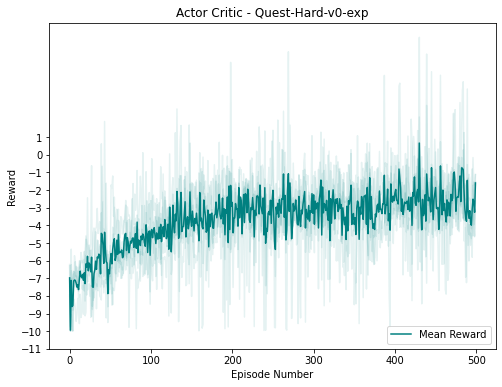

In [37]:
plot_results(env_name="Quest-Hard-v0-exp",scores=quest_hard_exp_scores, color = "teal" )

In [34]:
import csv

with open('quest_hard_exp.csv', 'w') as f:
    write = csv.writer(f) 
    for score in quest_hard_exp_scores:
        write.writerow(score) 

In [38]:
#Video Run
env = gym.make("MiniHack-Quest-Hard-v0", reward_manager = reward_gen, actions = QUEST_ACTIONS_2, observation_keys=["glyphs","pixel","message"])

model = ActorCritic(h_size=512, a_size=env.action_space.n).to(device)
policy_1, scores_1 = actor_critic(env=env, model= model, seed=42, learning_rate=0.02,
                           number_episodes=500, max_episode_length=1000, gamma=0.99 ,verbose=True)

Episode: 0 Reward: -7.26 Average Reward: -7.26 Steps 999


/home/thishen/.local/lib/python3.8/site-packages/torch/tensor.py:447: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/tmp/ipykernel_2817/61882409.py:83: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.smooth_l1_loss(value, reward)


Episode: 1 Reward: -9.329999999999998 Average Reward: -8.294999999999998 Steps 999
Episode: 2 Reward: -7.34 Average Reward: -7.976666666666666 Steps 999
Episode: 3 Reward: -9.989999999999998 Average Reward: -8.479999999999999 Steps 999
Episode: 4 Reward: -7.609999999999999 Average Reward: -8.306 Steps 999
Episode: 5 Reward: -7.31 Average Reward: -8.139999999999999 Steps 999
Episode: 6 Reward: -7.999999999999999 Average Reward: -8.12 Steps 999
Episode: 7 Reward: -9.989999999999998 Average Reward: -8.353749999999998 Steps 999
Episode: 8 Reward: -9.29 Average Reward: -8.457777777777775 Steps 999
Episode: 9 Reward: -6.9399999999999995 Average Reward: -8.305999999999997 Steps 999
Episode: 10 Reward: -7.529999999999999 Average Reward: -8.235454545454543 Steps 999
Episode: 11 Reward: -7.47 Average Reward: -8.171666666666665 Steps 999
Episode: 12 Reward: -6.799999999999999 Average Reward: -8.066153846153844 Steps 999
Episode: 13 Reward: -6.68 Average Reward: -7.967142857142854 Steps 999
Episod

Episode: 111 Reward: -5.140000000000001 Average Reward: -4.649399999999999 Steps 999
Episode: 112 Reward: -4.470000000000001 Average Reward: -4.6259999999999994 Steps 999
Episode: 113 Reward: -2.18 Average Reward: -4.5442 Steps 999
Episode: 114 Reward: -4.57 Average Reward: -4.444 Steps 999
Episode: 115 Reward: -6.7700000000000005 Average Reward: -4.4716 Steps 999
Episode: 116 Reward: -8.71 Average Reward: -4.5648 Steps 999
Episode: 117 Reward: -3.2800000000000002 Average Reward: -4.555 Steps 999
Episode: 118 Reward: -4.06 Average Reward: -4.549600000000001 Steps 999
Episode: 119 Reward: -9.2 Average Reward: -4.583600000000001 Steps 999
Episode: 120 Reward: -1.64 Average Reward: -4.5774 Steps 999
Episode: 121 Reward: -2.3600000000000003 Average Reward: -4.607200000000001 Steps 999
Episode: 122 Reward: -0.8799999999999999 Average Reward: -4.5628 Steps 999
Episode: 123 Reward: -0.04999999999999993 Average Reward: -4.5264 Steps 999
Episode: 124 Reward: -3.29 Average Reward: -4.5346 Steps 

Episode: 225 Reward: -3.789999999999999 Average Reward: -2.7803999999999998 Steps 999
Episode: 226 Reward: -4.73 Average Reward: -2.818199999999999 Steps 999
Episode: 227 Reward: -2.2700000000000005 Average Reward: -2.7878 Steps 999
Episode: 228 Reward: -0.9399999999999998 Average Reward: -2.7204 Steps 999
Episode: 229 Reward: -1.0899999999999999 Average Reward: -2.7973999999999997 Steps 999
Episode: 230 Reward: -3.75 Average Reward: -2.9200000000000004 Steps 999
Episode: 231 Reward: -4.709999999999999 Average Reward: -2.8766000000000003 Steps 999
Episode: 232 Reward: -4.2 Average Reward: -2.8842000000000003 Steps 999
Episode: 233 Reward: -3.4499999999999997 Average Reward: -2.918799999999999 Steps 999
Episode: 234 Reward: -2.0100000000000002 Average Reward: -2.8767999999999994 Steps 999
Episode: 235 Reward: -3.92 Average Reward: -2.8767999999999994 Steps 999
Episode: 236 Reward: -1.66 Average Reward: -2.8329999999999997 Steps 999
Episode: 237 Reward: -4.42 Average Reward: -2.813799999

Episode: 335 Reward: -3.7300000000000004 Average Reward: -3.652599999999999 Steps 999
Episode: 336 Reward: -3.2 Average Reward: -3.654399999999999 Steps 999
Episode: 337 Reward: -7.82 Average Reward: -3.8117999999999994 Steps 999
Episode: 338 Reward: -3.08 Average Reward: -3.7990000000000004 Steps 999
Episode: 339 Reward: -5.21 Average Reward: -3.8368000000000007 Steps 999
Episode: 340 Reward: -4.34 Average Reward: -3.8739999999999997 Steps 999
Episode: 341 Reward: -2.77 Average Reward: -3.8952000000000004 Steps 999
Episode: 342 Reward: -4.1 Average Reward: -3.9040000000000004 Steps 999
Episode: 343 Reward: -4.72 Average Reward: -3.9353999999999996 Steps 999
Episode: 344 Reward: -4.16 Average Reward: -3.9372 Steps 999
Episode: 345 Reward: -4.56 Average Reward: -3.9256 Steps 999
Episode: 346 Reward: -2.5500000000000003 Average Reward: -3.899200000000001 Steps 999
Episode: 347 Reward: -3.74 Average Reward: -3.9370000000000003 Steps 999
Episode: 348 Reward: -4.14 Average Reward: -3.9602 S

Episode: 447 Reward: -1.0899999999999999 Average Reward: -2.1737999999999995 Steps 999
Episode: 448 Reward: -3.3200000000000003 Average Reward: -2.1698000000000004 Steps 999
Episode: 449 Reward: -1.6599999999999997 Average Reward: -2.1578 Steps 999
Episode: 450 Reward: -3.24 Average Reward: -2.1781999999999995 Steps 999
Episode: 451 Reward: -1.48 Average Reward: -2.1807999999999996 Steps 999
Episode: 452 Reward: -1.4400000000000002 Average Reward: -2.1702 Steps 999
Episode: 453 Reward: -1.8399999999999999 Average Reward: -2.2060000000000004 Steps 999
Episode: 454 Reward: -3.1899999999999995 Average Reward: -2.237 Steps 999
Episode: 455 Reward: 0.0 Average Reward: -2.1957999999999998 Steps 999
Episode: 456 Reward: 4.1000000000000005 Average Reward: -2.024 Steps 999
Episode: 457 Reward: -2.04 Average Reward: -2.0330000000000004 Steps 999
Episode: 458 Reward: -1.79 Average Reward: -2.0086 Steps 999
Episode: 459 Reward: -4.01 Average Reward: -2.0420000000000003 Steps 999
Episode: 460 Rewar

In [41]:
#find video trajectory
num_test_runs = 20
best_ep_reward = -999999
best_trajectory = []
for i in range(num_test_runs):
    state = env.reset()
    done = False
    rewards = []
    trajectory = []
    while not done:
        action_probs,state_value = policy_1(format_state(state))
        distribution = torch.distributions.Categorical(action_probs)

        action = distribution.sample()

        
        next_state, reward, done, _ = env.step(action.item())
        rewards.append(reward)
        trajectory.append(next_state['pixel'])
        state = next_state
    ep_reward = np.sum(rewards)
    print(ep_reward)
    if ep_reward > best_ep_reward:
        best_trajectory = trajectory
        best_ep_reward = ep_reward

-2.22
4.0600000000000005
-2.5700000000000003
-4.0
-2.33
-6.77
0.3700000000000002
-2.33
-1.9899999999999998
-0.20999999999999985
-2.46
-3.2199999999999998
-2.3
-2.95
-2.6899999999999995
-2.16
-0.7100000000000001
0.01000000000000012
0.9100000000000001
-2.9800000000000004


In [42]:
#save video
from datetime import datetime

now = datetime.now()
run_start_datetime = now.strftime("%d-%m-%Y_%H-%M-%S")
torch.save(policy_1, f"{run_start_datetime}_ac_quest_hard.pt")

import cv2

frameSize = (1264, 336)

out = cv2.VideoWriter(f'{run_start_datetime}_video.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 60, frameSize)

for frame in best_trajectory:
    out.write(frame)

out.release()

OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
